## ラベル補正アルゴリズム検討
### ミスしたIDの数 (全ID数 (全てのサンプルをミスしたID数, 一部のサンプルをミスしたID数))
- dataset03: 63 (9, 54)
- dataset04: 79 (38, 41)
- dataset05: 42 (6, 38)

### 全てにミスが有る
補正できるパターンは見つからない
- dataset03:
  - 正解0, 予測1 (31, 53, 237, 429)
  - 正解0, 予測4 (702, 704)
  - 正解1, 予測0,2 (362, 671)
  - 正解4, 予測3  (200)
- dataset04:
  - 正解3, 予測0,1,2  (198, 207, 209, 224, 229, 236, 239, 240, 269, 272, 321, 323, 380, 428, 445, 483, 493, 515, 525, 560, 579, 697, 804)
  - 正解4, 予測0,3,2  (5, 8, 15, 22, 105, 165, 442, 534, 547, 710, 726, 733, 736, 742, 764)
- dataset05:
  - 正解0, 予測3 (9)
  - 正解3, 予測0 (164, 212, 252, 302)
  - 正解4, 予測0 (315)
### 一部にミスがある
- 最初にミスが有るパターンは無視 -> リアルタイムに対応できない
- ラベル信頼度の移動平均 -> 約1%精度上昇(05, 03), 約0.3%精度上昇(04)
そこまで補正できないため必要ない?

In [1]:
%cd /raid6/home/yokoyama/har-for-or/
import os
import sys
from glob import glob
import pickle

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score

sys.path.append(".")
from src.utils import video, yaml_handler, vis

/raid6/home/yokoyama/har-for-or


/raid6/home/yokoyama/har-for-or/.venv/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


# Train

In [2]:
# test
model_type = "sqvae"
dataset_num = 3
# if dataset_num == 3:
#     v = 0
# elif dataset_num == 4:
#     v = 1
# elif dataset_num == 5:
#     v = 2
v = 0
checkpoint_dir = f"models/individual/{model_type}/version_{v}"

# load annotation
path = glob(f"../datasets/dataset{dataset_num:02d}/annotation/*train*.txt")[0]
annotations = np.loadtxt(path, str, skiprows=1, delimiter=" ")

# load config
config = yaml_handler.load(f"{checkpoint_dir}/individual-{model_type}.yaml")
seq_len = config.seq_len
stride = config.stride

# load preds
if dataset_num < 6:
    data_root = f"../datasets/dataset{dataset_num:02d}/train/**"
else:
    raise NotImplementedError
print(data_root)
paths = glob(os.path.join(data_root, f"pred_{model_type}", "*"))
results = []
for path in paths:
    with open(path, "rb") as f:
        results.append(pickle.load(f))

../datasets/dataset03/train/**


In [3]:
label_preds = []
label_gts = []
miss_ids = []
ann_keys = annotations.T[0]
for result in results:
    key = result["key"]
    video_num, n_frame, _id = key.split("_")
    n_frame = int(n_frame)
    key = f"{video_num}_{_id}"
    label_pred = result["label"]

    ann_tmp = annotations[ann_keys == key]
    if len(ann_tmp) >= 2:
        # groud truth is chenged sometimes since the tracking model mistakes
        ann_n_frames = ann_tmp.T[2].astype(int)
        ann_tmp = ann_tmp[ann_n_frames <= n_frame][-1]
        label_gt = int(ann_tmp[1])
    elif len(ann_tmp) == 1:
        label_gt = int(ann_tmp[0, 1])
    else:
        continue  # cleansing
    label_preds.append(label_pred)
    label_gts.append(label_gt)

    if label_pred != label_gt and int(_id) not in miss_ids:
        miss_ids.append(int(_id))

miss_ids = np.array(miss_ids)

In [4]:
label_counts = {i: 0 for i in range(config.n_clusters)}
for label_gt in label_gts:
    label_counts[label_gt] += 1

label_counts = [(k, v) for k, v in label_counts.items()]
label_counts.append(("total", len(label_gts)))
label_counts

[(0, 3955), (1, 1454), (2, 2842), (3, 2845), (4, 3567), ('total', 14663)]

0.9598990656755098


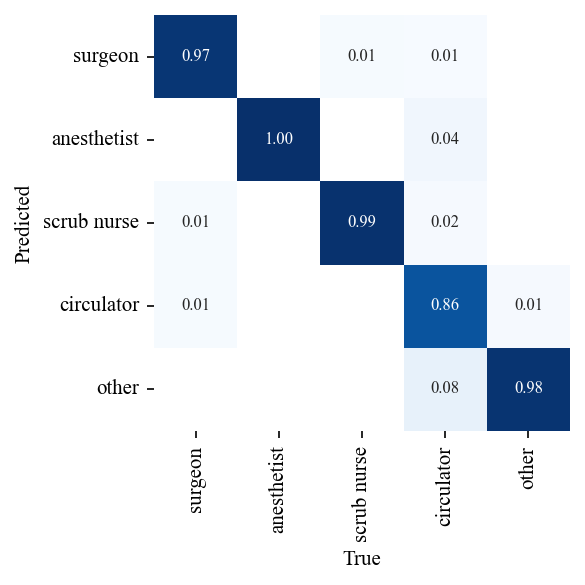

In [5]:
print(accuracy_score(label_gts, label_preds))
cm = confusion_matrix(label_gts, label_preds).T
path = f"../datasets/dataset{dataset_num:02d}/annotation/classes.txt"
labels = np.loadtxt(path, str, usecols=0, delimiter="\t")
vis.plot_cm(cm, labels, normalize=True, cbar=False)

# Test

In [6]:
# test
model_type = "sqvae"
dataset_num = 3
# if dataset_num == 3:
#     v = 0
# elif dataset_num == 4:
#     v = 1
# elif dataset_num == 5:
#     v = 2
v = 0
checkpoint_dir = f"models/individual/{model_type}/version_{v}"

# load annotation
path = glob(f"../datasets/dataset{dataset_num:02d}/annotation/*test*.txt")[0]
video_num = int(os.path.basename(path).split(".")[0].split("_")[2])
annotations = np.loadtxt(path, str, skiprows=1, delimiter=" ")

# load config
config = yaml_handler.load(f"{checkpoint_dir}/individual-{model_type}.yaml")
seq_len = config.seq_len
stride = config.stride

# load preds
if dataset_num < 6:
    data_root = f"../datasets/dataset{dataset_num:02d}/test/{video_num:02d}"
else:
    data_root = f"../datasets/dataset{dataset_num:02d}/{video_num:02d}"
print(data_root)
paths = glob(os.path.join(data_root, f"pred_{model_type}", "*"))
results = []
for path in paths:
    with open(path, "rb") as f:
        results.append(pickle.load(f))

../datasets/dataset03/test/07


In [7]:
label_preds = []
label_gts = []
miss_ids = []
ann_keys = annotations.T[0]
for result in results:
    key = result["key"]
    video_num, n_frame, _id = key.split("_")
    n_frame = int(n_frame)
    key = f"{video_num}_{_id}"
    label_pred = result["label"]
    label_preds.append(label_pred)

    ann_tmp = annotations[ann_keys == key]
    if len(ann_tmp) >= 2:
        # groud truth is chenged sometimes since the tracking model mistakes
        ann_n_frames = ann_tmp.T[2].astype(int)
        ann_tmp = ann_tmp[ann_n_frames <= n_frame][-1]
        label_gt = int(ann_tmp[1])
    elif len(ann_tmp) == 1:
        label_gt = int(ann_tmp[0, 1])
    else:
        print(key)
        raise ValueError
    label_gts.append(label_gt)

    if label_pred != label_gt and int(_id) not in miss_ids:
        miss_ids.append(int(_id))

miss_ids = np.array(miss_ids)

In [8]:
label_counts = {i: 0 for i in range(config.n_clusters)}
for label_gt in label_gts:
    label_counts[label_gt] += 1

label_counts = [(k, v) for k, v in label_counts.items()]
label_counts.append(("total", len(label_gts)))
label_counts

[(0, 2430), (1, 1096), (2, 1707), (3, 1306), (4, 3581), ('total', 10120)]

0.958794466403162


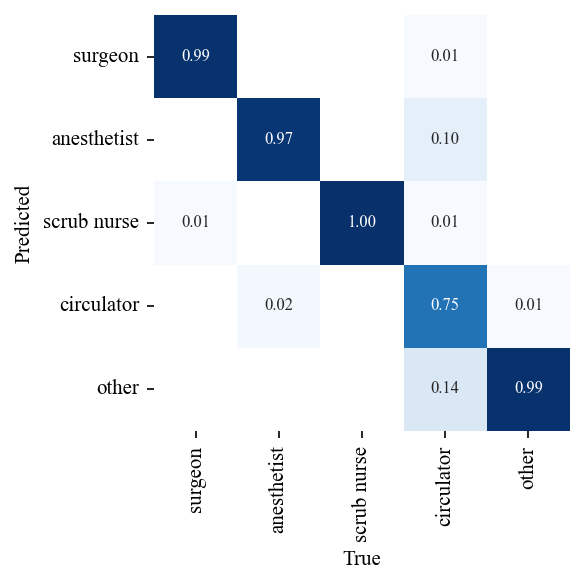

In [9]:
print(accuracy_score(label_gts, label_preds))
cm = confusion_matrix(label_gts, label_preds).T
path = f"../datasets/dataset{dataset_num:02d}/annotation/classes.txt"
labels = np.loadtxt(path, str, usecols=0, delimiter="\t")
vis.plot_cm(cm, labels, normalize=True, cbar=False)

In [10]:
len(miss_ids)

41

In [11]:
miss_samples = {}
for r, label_gt in zip(results, label_gts):
    video_num, n_frame, _id = r["key"].split("_")
    n_frame = int(n_frame)
    _id = int(_id)
    label_pred = r["label"]
    c0, c1, c2, c3, c4 = r["label_prob"]
    x1, y1, x2, y2 = r["bbox"][-1].reshape(-1)

    if _id in miss_ids and _id not in miss_samples:
        miss_samples[_id] = []

    if _id in miss_samples:
        miss_samples[_id].append(
            (n_frame, label_pred, label_gt, c0, c1, c2, c3, c4, x1, y1, x2, y2)
        )

In [12]:
# all labels are fail
miss_ids_all = []
for _id, sample in miss_samples.items():
    sample = np.array(sample)
    if np.all(sample.T[1] != sample.T[2]):
        miss_ids_all.append(_id)

miss_ids_all = np.array(miss_ids_all)
len(miss_ids_all)

4

In [13]:
miss_ids_part = miss_ids[~np.isin(miss_ids, miss_ids_all)]
len(miss_ids_part)

37

In [14]:
miss_ids_all

array([105, 258, 504, 631])

In [15]:
# count = 0
# for _id in miss_ids_all:
#     sample = np.array(miss_samples[_id]).astype(int)
#     if np.all(sample.T[2] == 3):
#         print(_id)
#         print(sample.T[:3].T)
#     count += len(sample)
# print(count)

In [16]:
miss_ids_part

array([ 31,   1,  36, 114,  73,  69, 109, 141, 149,   5,  85, 182, 200, 203, 242, 219, 277, 294, 264, 314, 293, 312, 350, 464, 423, 501, 482, 648, 657,  74, 647, 684, 667, 721, 676, 685, 655])

# 全てに間違いがあるデータ

2


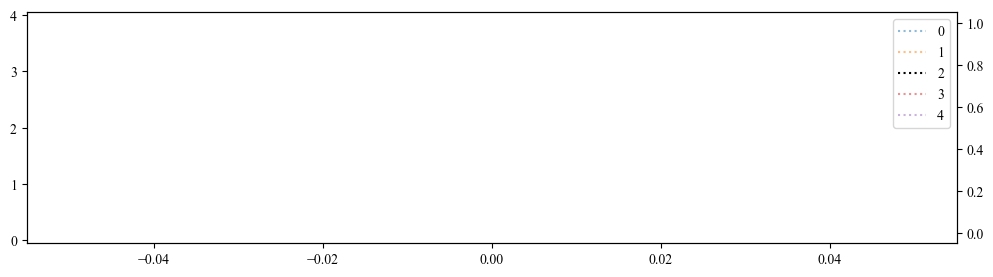

3


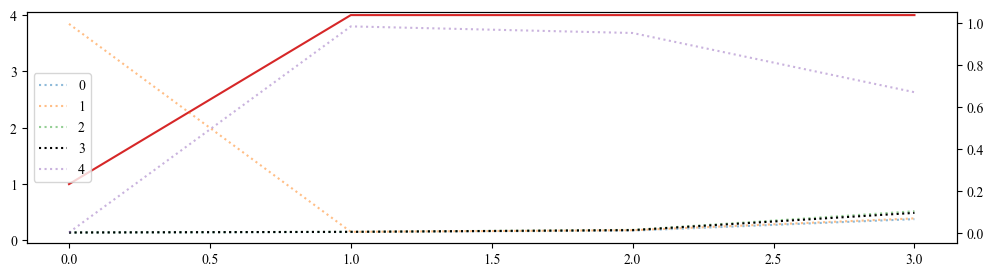

4


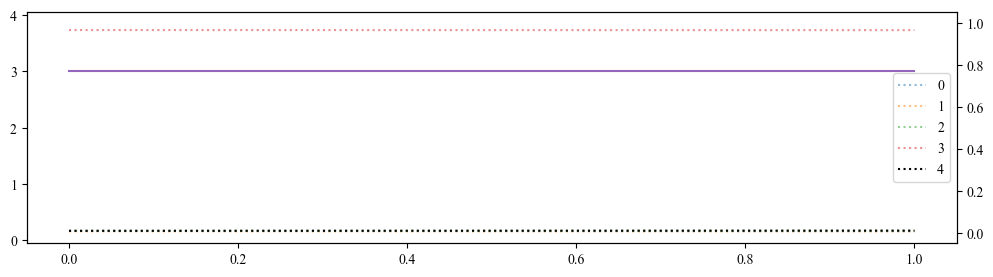

In [17]:
label_preds = []
label_gts = []
label_confs = []
for _id in miss_ids_all:
    sample = miss_samples[_id]
    sample = np.array(sample)
    label_preds += sample.T[1].tolist()
    label_gts += sample.T[2].tolist()
    label_confs += sample.T[3:8].T.tolist()
label_preds = np.array(label_preds).astype(int)
label_gts = np.array(label_gts).astype(int)
label_confs = np.array(label_confs)

cm = plt.get_cmap("tab10")
for label_gt in np.unique(label_gts):
    print(label_gt)
    fig = plt.figure(figsize=(12, 3))
    ax = fig.subplots()
    ax1 = ax.twinx()
    mask = label_gts == label_gt
    preds_tmp = label_preds[mask]

    # plot label
    c = cm(label_gt)
    ax.plot(label_preds[mask], c=c, label=label_gt)
    ax.set_ylim(-0.05, 4.05)

    # plot conf
    for l in range(config.n_clusters):
        if l != label_gt:
            ax1.plot(
                label_confs[mask][:, l], c=cm(l), alpha=0.5, linestyle=":", label=l
            )
        else:
            ax1.plot(label_confs[mask][:, l], c="black", linestyle=":", label=l)
    ax1.set_ylim(-0.05, 1.05)

    plt.legend()
    plt.show()

2


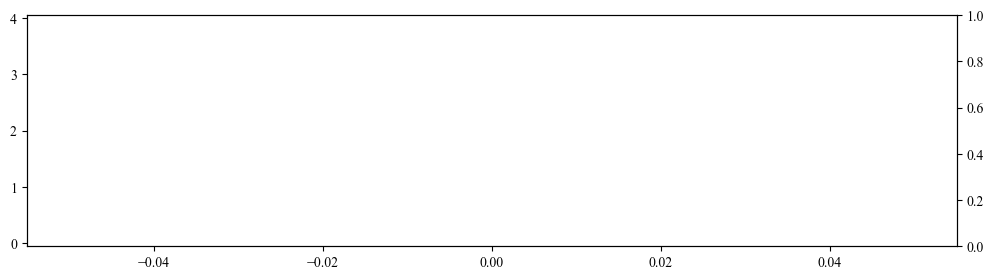

3


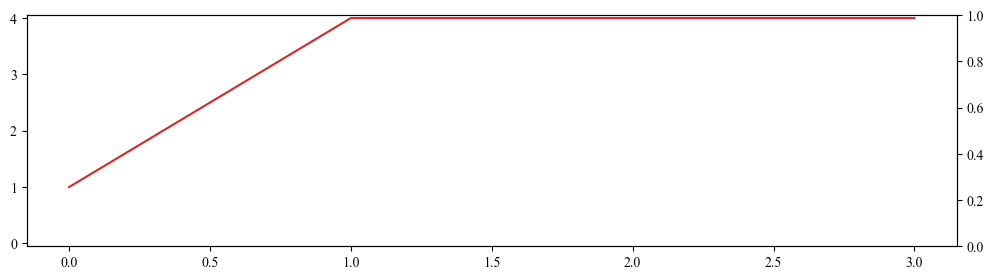

4


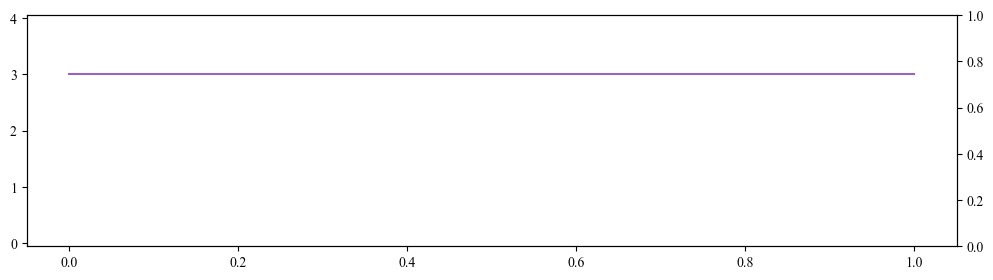

In [18]:
def correction(label_preds, label_confs, length=10):
    que_confs = []
    results = []
    for label, conf in zip(label_preds, label_confs):
        que_confs.append(conf)

        confs_tmp = np.array(que_confs)
        # weights = (np.arange(len(que_confs)) + 1) * 1 / length
        # confs_tmp = confs_tmp * weights.reshape(-1, 1)
        confs_tmp = np.mean(confs_tmp, axis=0)
        label = np.argmax(confs_tmp)
        results.append(label)

        if len(que_confs) == length:
            que_confs = que_confs[1:]
    return results


label_preds = []
label_gts = []
label_confs = []
for _id in miss_ids_all:
    sample = miss_samples[_id]
    sample = np.array(sample)
    label_gts += sample.T[2].tolist()
    label_preds_tmp = sample.T[1].tolist()
    label_confs_tmp = sample.T[3:8].T.tolist()
    label_preds_tmp = correction(label_preds_tmp, label_confs_tmp)
    label_preds += label_preds_tmp
    label_confs += label_confs_tmp
label_preds = np.array(label_preds).astype(int)
label_gts = np.array(label_gts).astype(int)
label_confs = np.array(label_confs)

cm = plt.get_cmap("tab10")
for label_gt in np.unique(label_gts):
    print(label_gt)
    fig = plt.figure(figsize=(12, 3))
    ax = fig.subplots()
    ax1 = ax.twinx()
    mask = label_gts == label_gt
    preds_tmp = label_preds[mask]

    # plot label
    c = cm(label_gt)
    ax.plot(label_preds[mask], c=c, label=label_gt)
    ax.set_ylim(-0.05, 4.05)

    # plot conf
    # max_conf = np.max(label_confs, axis=1)
    # ax1.plot(label_confs[mask][:1000, label_gt], c="black", alpha=0.5, linestyle=":")
    # ax1.plot(max_conf[mask][:1000], c="blue", alpha=0.5, linestyle=":")
    # ax1.set_ylim(-0.05, 1.05)

    plt.show()

# 一部に間違いがあるデータ

0


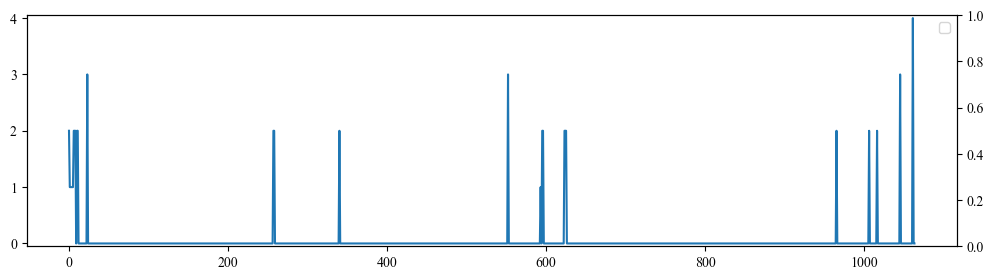

1


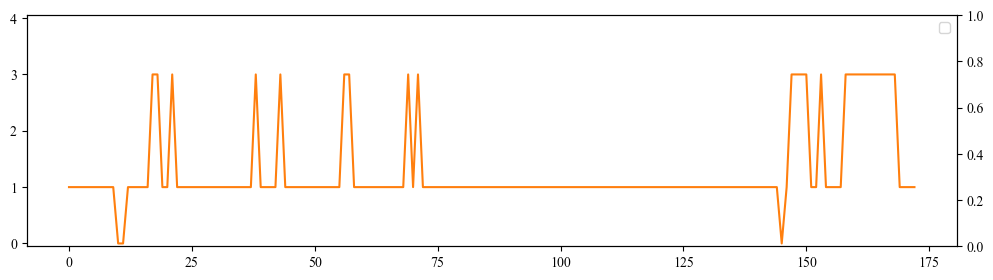

2


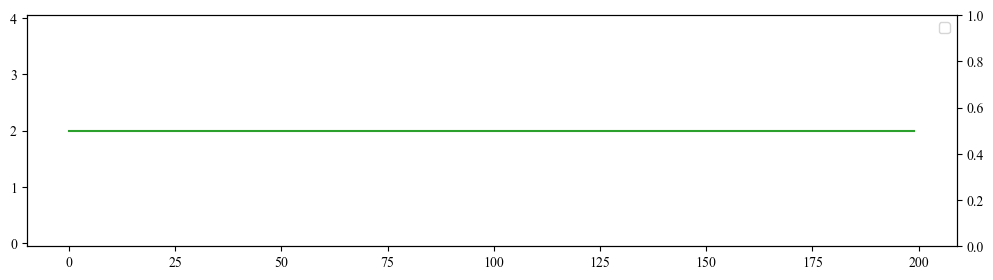

3


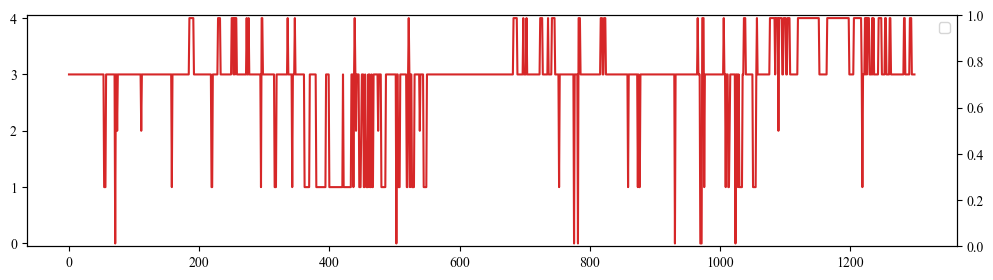

4


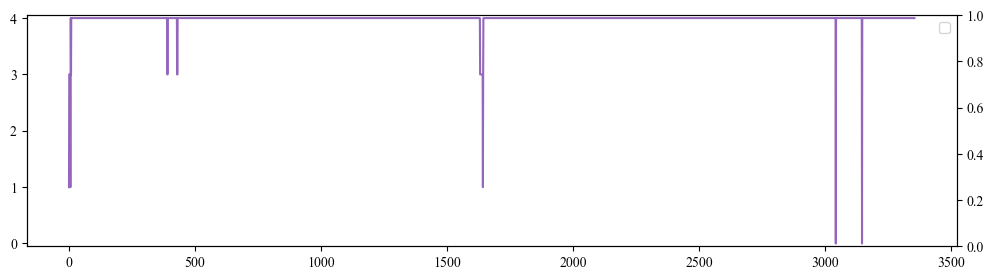

In [19]:
label_preds = []
label_gts = []
label_confs = []
for _id in miss_ids_part:
    sample = miss_samples[_id]
    sample = np.array(sample)
    label_preds += sample.T[1].tolist()
    label_gts += sample.T[2].tolist()
    label_confs += sample.T[3:8].T.tolist()
label_preds = np.array(label_preds).astype(int)
label_gts = np.array(label_gts).astype(int)
label_confs = np.array(label_confs)

cm = plt.get_cmap("tab10")
for label_gt in np.unique(label_gts):
    print(label_gt)
    fig = plt.figure(figsize=(12, 3))
    ax = fig.subplots()
    ax1 = ax.twinx()
    mask = label_gts == label_gt
    preds_tmp = label_preds[mask]

    # plot label
    c = cm(label_gt)
    ax.plot(label_preds[mask], c=c, label=label_gt)
    ax.set_ylim(-0.05, 4.05)

    # plot conf
    # for l in range(config.n_clusters):
    #     if l != label_gt:
    #         ax1.plot(
    #             label_confs[mask][:, l], c=cm(l), alpha=0.5, linestyle=":", label=l
    #         )
    #     else:
    #         ax1.plot(label_confs[mask][:, l], c="black", linestyle=":", label=l)
    # ax1.set_ylim(-0.05, 1.05)

    plt.legend()
    plt.show()

0


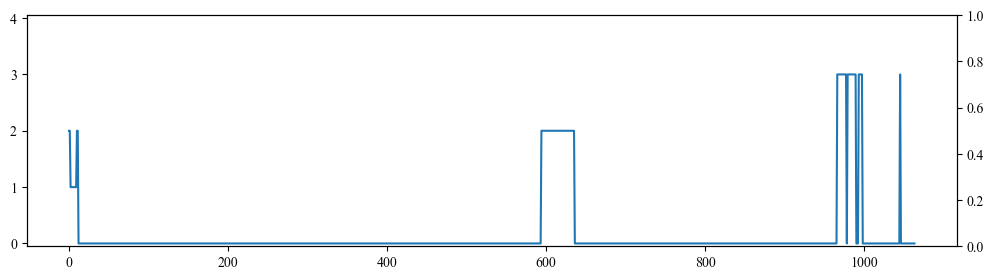

1


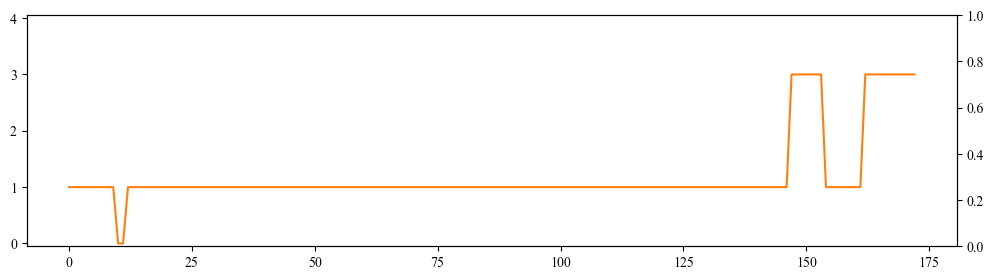

2


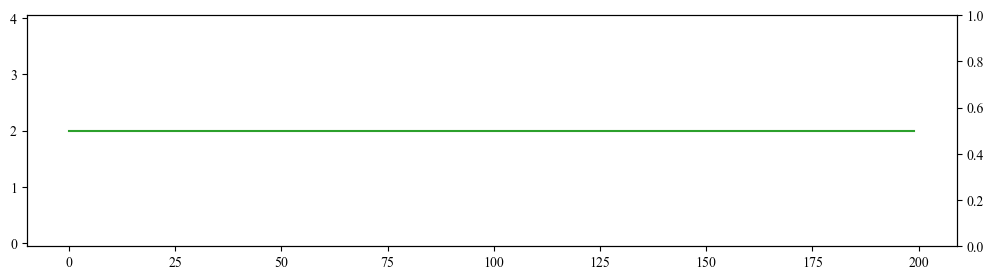

3


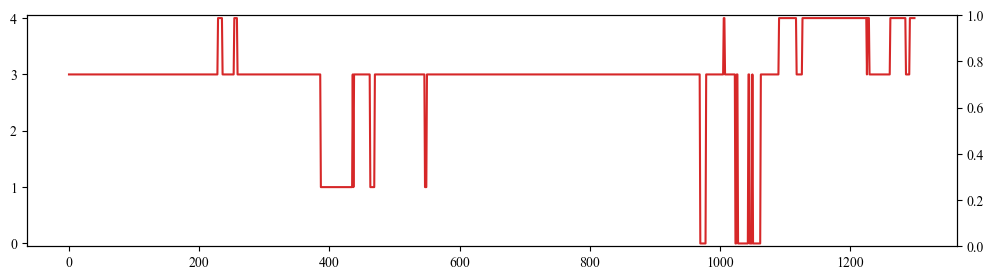

4


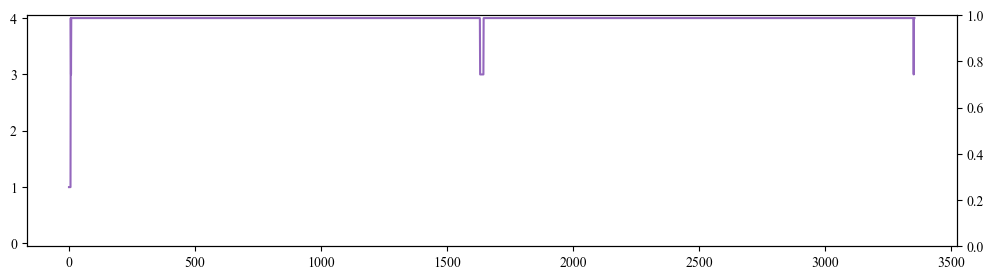

In [20]:
def correction(label_preds, label_confs, length=30):
    que_confs = []
    results = []
    for label, conf in zip(label_preds, label_confs):
        que_confs.append(conf)

        confs_tmp = np.array(que_confs)
        # weights = (np.arange(len(que_confs)) + 1) * 1 / length
        # confs_tmp = confs_tmp * weights.reshape(-1, 1)
        confs_tmp = np.mean(confs_tmp, axis=0)
        label = np.argmax(confs_tmp)
        results.append(label)

        if len(que_confs) == length:
            que_confs = que_confs[1:]
    return results


label_preds = []
label_gts = []
label_confs = []
for _id in miss_ids_part:
    sample = miss_samples[_id]
    sample = np.array(sample)
    label_gts += sample.T[2].tolist()
    label_preds_tmp = sample.T[1].tolist()
    label_confs_tmp = sample.T[3:8].T.tolist()
    label_preds_tmp = correction(label_preds_tmp, label_confs_tmp)
    label_preds += label_preds_tmp
    label_confs += label_confs_tmp
label_preds = np.array(label_preds).astype(int)
label_gts = np.array(label_gts).astype(int)
label_confs = np.array(label_confs)

cm = plt.get_cmap("tab10")
for label_gt in np.unique(label_gts):
    print(label_gt)
    fig = plt.figure(figsize=(12, 3))
    ax = fig.subplots()
    ax1 = ax.twinx()
    mask = label_gts == label_gt
    preds_tmp = label_preds[mask]

    # plot label
    c = cm(label_gt)
    ax.plot(label_preds[mask], c=c, label=label_gt)
    ax.set_ylim(-0.05, 4.05)

    # plot conf
    # max_conf = np.max(label_confs, axis=1)
    # ax1.plot(label_confs[mask][:1000, label_gt], c="black", alpha=0.5, linestyle=":")
    # ax1.plot(max_conf[mask][:1000], c="blue", alpha=0.5, linestyle=":")
    # ax1.set_ylim(-0.05, 1.05)

    plt.show()

In [21]:
result_ids = {}
ann_keys = annotations.T[0]
for result in results:
    key = result["key"]
    video_num, n_frame, _id = key.split("_")
    n_frame = int(n_frame)
    _id = int(_id)
    key = f"{video_num}_{_id}"
    label_pred = result["label"]
    label_conf = result["label_prob"]

    ann_tmp = annotations[ann_keys == key]
    if len(ann_tmp) >= 2:
        # groud truth is chenged sometimes since the tracking model mistakes
        ann_n_frames = ann_tmp.T[2].astype(int)
        ann_tmp = ann_tmp[ann_n_frames <= n_frame][-1]
        label_gt = int(ann_tmp[1])
    else:
        label_gt = int(ann_tmp[0, 1])

    if _id not in result_ids:
        result_ids[_id] = dict(label_preds=[], label_gts=[], label_confs=[])
    result_ids[_id]["label_preds"].append(label_pred)
    result_ids[_id]["label_gts"].append(label_gt)
    result_ids[_id]["label_confs"].append(label_conf)

In [22]:
for _id, items in result_ids.items():
    label_preds = items["label_preds"]
    label_confs = items["label_confs"]
    label_preds = correction(label_preds, label_confs, length=10)
    result_ids[_id]["label_preds"] = label_preds

0.9571146245059289


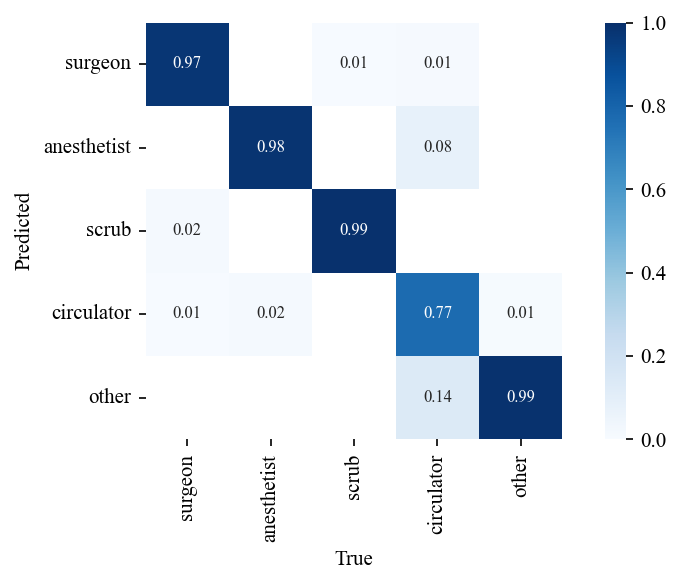

In [23]:
label_preds = []
label_gts = []
for items in result_ids.values():
    label_preds += items["label_preds"]
    label_gts += items["label_gts"]

print(accuracy_score(label_gts, label_preds))
cm = confusion_matrix(label_gts, label_preds).T
path = f"../datasets/dataset{dataset_num:02d}/annotation/classes.txt"
labels = np.loadtxt(path, str, usecols=0)
vis.plot_cm(cm, labels, normalize=True)

# 間違いの分布を表示

ground truth


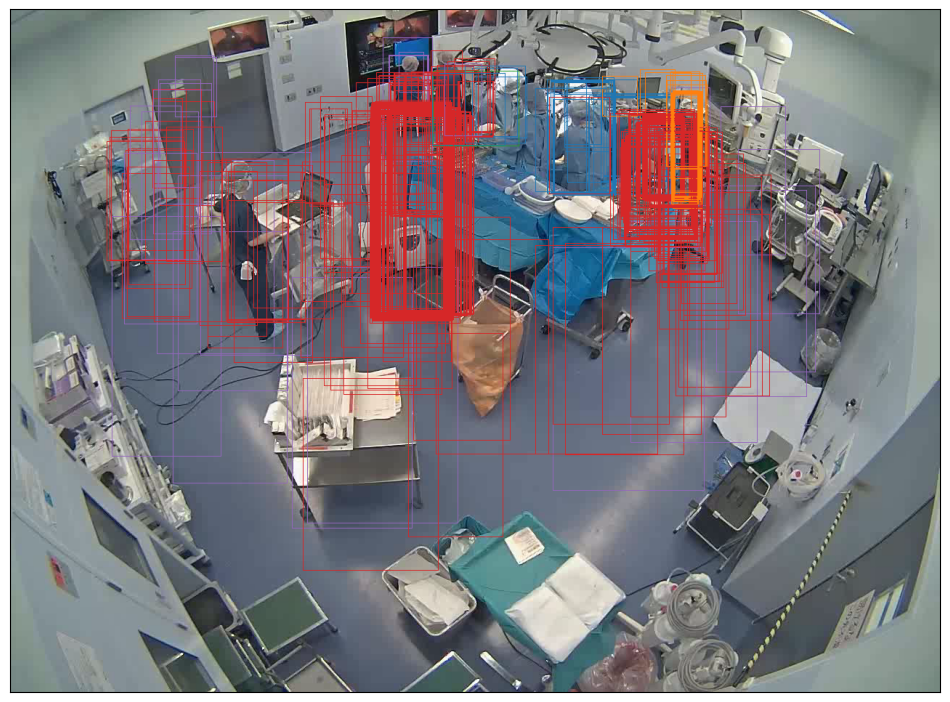

pred


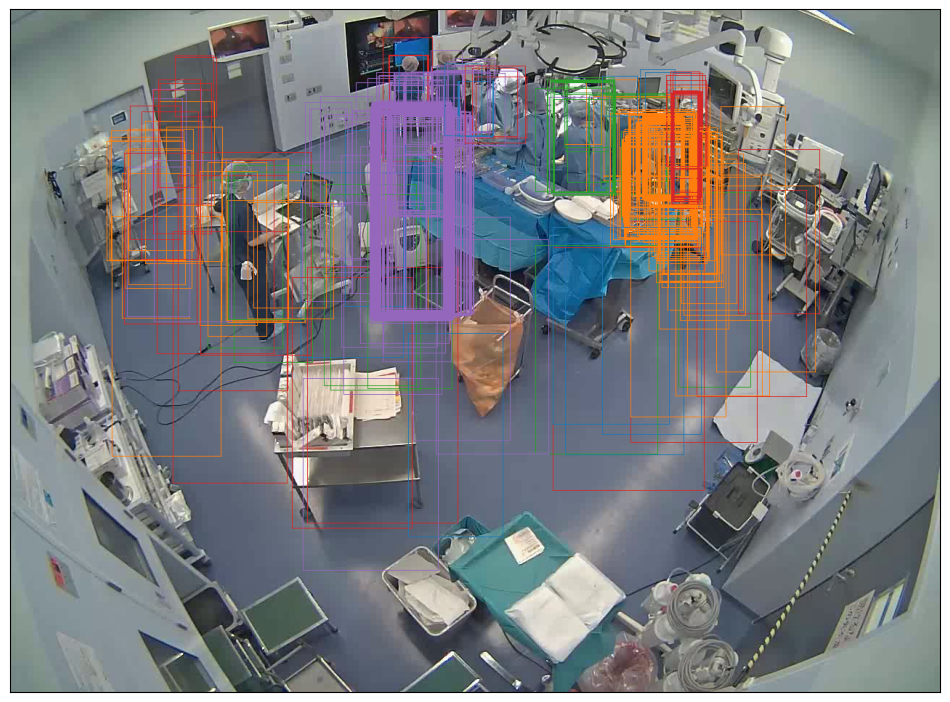

True

In [24]:
img_dir = f"../datasets/dataset{dataset_num:02d}/images"
os.makedirs(img_dir, exist_ok=True)

# load frame
cap = video.Capture(f"{data_root}.mp4")
frame = cap.read()[1]
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
size = cap.size
del cap

# scatter of bbox in all samples are fail
bboxs_all = []
label_preds = []
label_gts = []
for _id in miss_ids:
    sample = miss_samples[_id]
    sample = np.array(sample)
    x1, y1, x2, y2 = sample.T[8:]
    bboxs = sample.T[8:]
    for bbox in bboxs.T:
        bbox = vis.NormalizeBbox.reverse(bbox.reshape(2, 2), size, config.range_points)
        bboxs_all.append(bbox.reshape(4))
    label_preds += sample.T[1].astype(int).tolist()
    label_gts += sample.T[2].astype(int).tolist()

# plot
# frame[:, :, 3] = (frame[:, :, 3] * 0.7).astype(np.uint8)
frame_gt = frame.copy()
frame_pred = frame.copy()
cm = plt.get_cmap("tab10")

print("ground truth")
for bbox, label_gt, label_pred in zip(bboxs_all, label_gts, label_preds):
    if label_gt != label_pred:
        color = (np.array(cm(label_gt)) * 255).astype(int).tolist()
        pt1 = bbox[:2].astype(int).tolist()
        pt2 = bbox[2:].astype(int).tolist()
        frame_gt = cv2.rectangle(frame_gt, pt1, pt2, color, 1)
figsize = (size[0] // 100, size[1] // 100)
fig = plt.figure(figsize=figsize, dpi=100)
plt.imshow(frame_gt)
plt.xticks([])
plt.yticks([])
plt.show()

frame_gt = cv2.cvtColor(frame_gt, cv2.COLOR_RGBA2BGRA)
cv2.imwrite(f"{img_dir}/scatter_miss_bbox_gt.png", frame_gt)

print("pred")
for bbox, label_gt, label_pred in zip(bboxs_all, label_gts, label_preds):
    if label_gt != label_pred:
        color = (np.array(cm(label_pred)) * 255).astype(int).tolist()
        # color[3] = int(color[3] * 0.3)
        pt1 = bbox[:2].astype(int).tolist()
        pt2 = bbox[2:].astype(int).tolist()
        frame_pred = cv2.rectangle(frame_pred, pt1, pt2, color, 1)
figsize = (size[0] // 100, size[1] // 100)
fig = plt.figure(figsize=figsize, dpi=100)
plt.imshow(frame_pred)
plt.xticks([])
plt.yticks([])
plt.show()

frame_pred = cv2.cvtColor(frame_pred, cv2.COLOR_RGBA2BGRA)
cv2.imwrite(f"{img_dir}/scatter_miss_bbox_pred.png", frame_pred)